####           \\  ------------------------ | Boston Housing |  Assignment 3  | -----------------------/
# \\--------------- | Deep Learning | ---------------/

    \--------------------------| Emily Klassen |----------------------------/
    
                                      |  |

This is a regressive predictive modelling problem. This dataset describes properties of houses in the Boston suburb area and the following modelling attempts to predict the cost of such houses. There are 13 input variables. 

In [2]:
#importing dataset and libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image as mpl
from keras.models import Sequential 
from keras.layers import Dense 
from keras.wrappers.scikit_learn import KerasRegressor 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
%matplotlib inline
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

In [3]:
import io

housing = pd.read_csv(r"C:\Users\eklas\OneDrive\Desktop\CSV\Boston.csv")
# dataset = dataframe.values
pd.options.display.max_rows = 5 #10 max rows so going forward it's not so messy to look at
housing
# housing.head(5) #showing first 5 rows here

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,505,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0
505,506,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,396.90,7.88,11.9


Columns: 
- crim - per capita crime rate per town
- zn - proportion of residential land zoned for lots over 25,000 sq ft
- indus - proportion of non-retail business acres per town
- chas - Charles River dummy variable (1 = tract bounds the river, 0 = it does not)
- nox - nitric oxide concentration (pp 10 million).
- rm - avg number of rooms per domicile
- age - proportion of owner-occupied units prior to 1940
- dis - weighted distances to 5 Boston employment centres
- rad - index of accessibility to radial highways
- tax - full-value property tax rate per $10,000
- pt ratio - pupil:teacher ratio
- black - proportion of African Americans by town
- lstat -  % of lower status income per town 
- medv - median value of owner-occupied homes in \\$1000

- 16 data points with a ‘MEDV’ value of 50.0 will be removed, as they likely contain censored or missing values.
- 1 data point with a ‘RM’ value of 8.78 it is considered an outlier and will be removed for the optimal performance of the model.

In [4]:
# I don't like the all-lowercase situation.
# Map the capitalizing function to all column names
housing.columns = map(str.capitalize, housing.columns)
# rename couple cols that have dumb names
housing = housing.rename(columns={'Medv':'Price', 'Rm': 'Room'}) 
# Unnamed adds nothing, drop it like it's hot
housing.drop(['Unnamed: 0'], inplace = True, axis = 1)

In [5]:
housing = housing[housing.Price != 50]

In [6]:
housing = housing[housing.Price != 8.78]

In [7]:
housing.columns.tolist()
# that works.

['Crim',
 'Zn',
 'Indus',
 'Chas',
 'Nox',
 'Room',
 'Age',
 'Dis',
 'Rad',
 'Tax',
 'Ptratio',
 'Black',
 'Lstat',
 'Price']

In [8]:
# Let's have a look at the nulls situation.

housing.isnull().sum()
# huzzah, 0 nulls.

Crim     0
Zn       0
        ..
Lstat    0
Price    0
Length: 14, dtype: int64

In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Crim     490 non-null    float64
 1   Zn       490 non-null    float64
 2   Indus    490 non-null    float64
 3   Chas     490 non-null    int64  
 4   Nox      490 non-null    float64
 5   Room     490 non-null    float64
 6   Age      490 non-null    float64
 7   Dis      490 non-null    float64
 8   Rad      490 non-null    int64  
 9   Tax      490 non-null    int64  
 10  Ptratio  490 non-null    float64
 11  Black    490 non-null    float64
 12  Lstat    490 non-null    float64
 13  Price    490 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 57.4 KB


In [10]:
# pretty print statement for nulls.

nulls = housing.isnull().sum()
nulls = nulls.sum()
 
print('\nThere are', housing.shape[0],'rows in the dataset.')
print('There are', housing.shape[1],'columns (features) in the dataset.')
print('There are {}'.format(nulls),'nulls in the dataset.')

if nulls < 1:
    print("\nGreat.")
else:
    print("Imma quarantine you null like you're coughing")


There are 490 rows in the dataset.
There are 14 columns (features) in the dataset.
There are 0 nulls in the dataset.

Great.


In [12]:
housing.describe()

,Crim,Zn,Indus,Chas,Nox,Room,Age,Dis,Rad,Tax,Ptratio,Black,Lstat,Price
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000,490.000000,490.000000,490.00,490.000000,490.00000,490.000000
mean,3.643241,11.112245,11.113143,0.059184,0.554307,6.245471,68.27898,3.834519,9.514286,408.002041,18.52,355.855449,12.92402,21.635918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75%,3.647422,12.500000,18.100000,0.000000,0.624000,6.578000,93.87500,5.214600,24.000000,666.000000,20.20,396.322500,17.11750,24.675000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.00000,12.126500,24.000000,711.000000,22.00,396.900000,37.97000,48.800000


In [11]:
# Summary statistics
# sklearn.datasets.load_boston(return_X_y=False)

Price = housing['Price']*10000
minimum_price = np.min(Price)
maximum_price = np.max(Price)
mean_price = np.mean(Price)
median_price = np.median(Price)
std_price = np.std(Price)
# Alternative using pandas 


# There are other statistics you can calculate too like quartiles
first_quartile = np.percentile(Price, 25)
third_quartile = np.percentile(Price, 75)
inter_quartile = third_quartile - first_quartile

# Show the calculated statistics
print ("Statistics for Boston housing dataset:\n")
print ("Minimum price: ${:,.2f}".format(minimum_price))
print ("Maximum price: ${:,.2f}".format(maximum_price))
print ("Mean price: ${:,.2f}".format(mean_price))
print ("Median price ${:,.2f}".format(median_price))
print ("Standard deviation of prices: ${:,.2f}".format(std_price))
print ("First quartile of prices: ${:,.2f}".format(first_quartile))
print ("Second quartile of prices: ${:,.2f}".format(third_quartile))
print ("Interquartile (IQR) of prices: ${:,.2f}".format(inter_quartile))

Statistics for Boston housing dataset:

Minimum price: $50,000.00
Maximum price: $488,000.00
Mean price: $216,359.18
Median price $209,000.00
Standard deviation of prices: $78,572.71
First quartile of prices: $167,000.00
Second quartile of prices: $246,750.00
Interquartile (IQR) of prices: $79,750.00


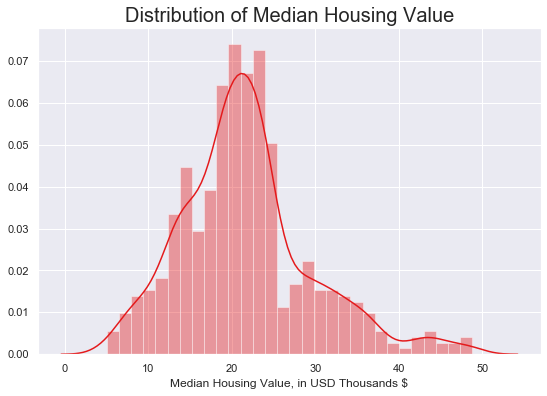

In [12]:
# Exploratory Data Analysis
from matplotlib import style
style.use('seaborn-bright')

sns.set(rc={'figure.figsize':(9,6)}, palette = 'Set1')
sns.distplot(housing['Price'], bins=30)
plt.title('Distribution of Median Housing Value', size = 20)
plt.xlabel('Median Housing Value, in USD Thousands $')
plt.show()

In [15]:
#Predictive model - check for correlation 

val = housing.corr() #finds linear pearson correlation
val = val [val < 1] #to avoid correlating values with themselves (ie corr = 1)
val

,Crim,Zn,Indus,Chas,Nox,Room,Age,Dis,Rad,Tax,Ptratio,Black,Lstat,Price
Crim,NaN,-0.199075,0.408053,-0.064210,0.420476,-0.219307,0.353751,-0.382231,0.627434,0.583711,0.287079,-0.384460,0.461755,-0.450115
Zn,-0.199075,NaN,-0.527121,-0.053911,-0.512137,0.310506,-0.563184,0.673227,-0.307726,-0.302897,-0.381815,0.176117,-0.422090,0.404608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lstat,0.461755,-0.422090,0.636527,-0.006486,0.612444,-0.610369,0.637879,-0.536493,0.510192,0.566467,0.358023,-0.364099,NaN,-0.759837
Price,-0.450115,0.404608,-0.600005,0.074803,-0.524451,0.686634,-0.492915,0.368813,-0.476296,-0.572442,-0.518641,0.364928,-0.759837,NaN


Text(0.5, 1, 'Boston Housing Correlation Heatmap\n')

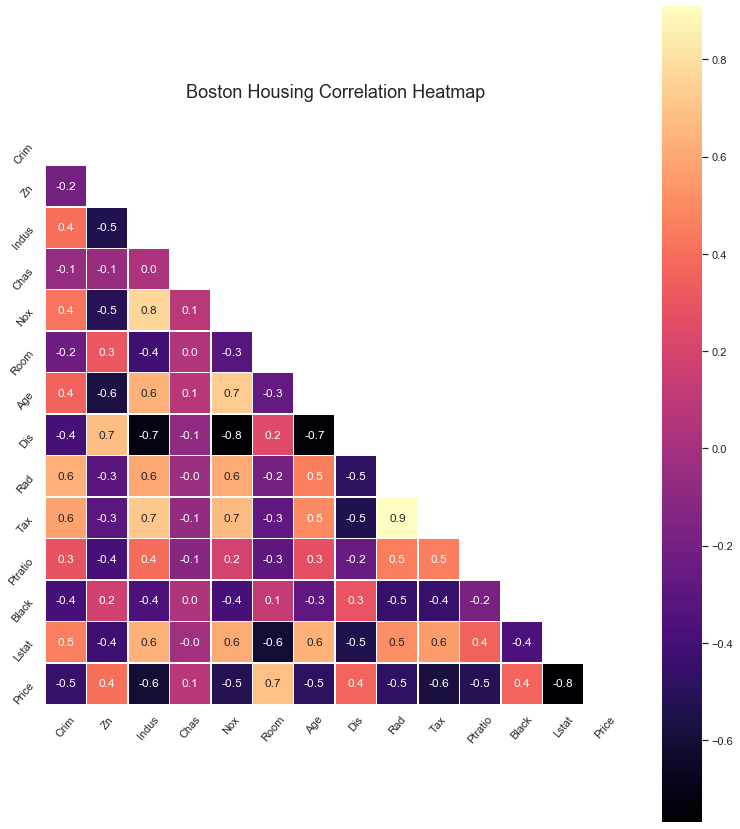

In [40]:
# Visualize

mask = np.full_like(val,0) #alternatively, can use np.zeros_like(result)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f,ax=plt.subplots(figsize=(13,15))
sns.heatmap(val, cbar=True, square=True, annot=True, fmt= '.1f',
           xticklabels=True, yticklabels=True, 
           cmap='magma', linewidths=.5, mask=mask, ax=ax)
plt.yticks(rotation=50)
plt.xticks(rotation = 50)
plt.title("Boston Housing Correlation Heatmap\n", size = 18)

In [ ]:
# Price is most highly correlated with Number of Rooms (positive corr), and Lstat (negative corr)

In [13]:
# split into input (X) and output (Y) variables 
import sklearn
from sklearn.model_selection import train_test_split
sklearn.model_selection.train_test_split
from sklearn.metrics import r2_score

X = housing.drop('Price', axis=1)
y = housing['Price']

# Basic linear regression  model

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.33, random_state = 7)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (328, 13)
X_test shape:  (162, 13)
y_train shape:  (328,)
y_test shape:  (162,)


Text(0.5, 1.0, 'Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$')

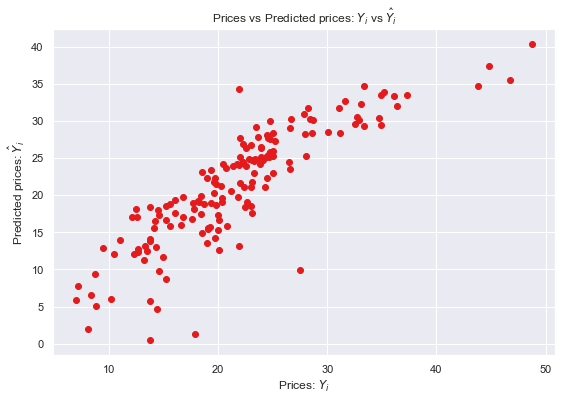

In [14]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

In [15]:
# MSE (mean squared error) of Linear Model tells us the difference between actual value and the predicted value
import numpy as np

mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
std = np.std(mse)

print("Linear Regression Model: ")
print("MSE: {:.2f} ".format(mse))

Linear Regression Model: 
MSE: 17.06 


In [20]:
housing1 = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
housing2 = housing1.head(10)
housing2

,Actual,Predicted
248,24.5,22.281849
60,18.7,18.854038
...,...,...
13,20.4,19.680155
492,20.1,12.681476


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

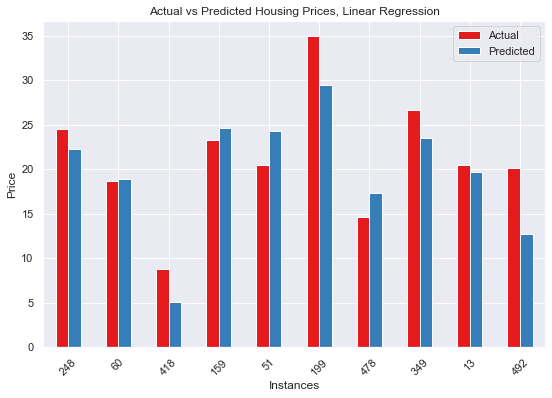

In [21]:
housing2.plot(kind = 'bar')
plt.title("Actual vs Predicted Housing Prices, Linear Regression")
plt.xlabel("Instances")
plt.ylabel("Price")
plt.xticks(rotation = 45)

In [16]:
# Linear Model Evaluation

from sklearn import metrics
from sklearn.metrics import r2_score
lin_mae = metrics.mean_absolute_error(y_test,y_pred)
lin_mse = metrics.mean_squared_error(y_test, y_pred)
lin_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
lin_r2 =  r2_score(y_test, y_pred)

print("Linear Regression Model Performance: ")
print('MAE: {:.2f}'.format(lin_mae))
print('MSE: {:.2f}'.format(lin_mse))
print('RMSE: {:.2f}'.format(lin_rmse))
print('R squared error: {:.2f}'.format(lin_r2))
# 67# of the variance in the y-variable can be explained by the X-variables. 

Linear Regression Model Performance: 
MAE: 3.00
MSE: 17.06
RMSE: 4.13
R squared error: 0.70


<Figure size 648x432 with 0 Axes>

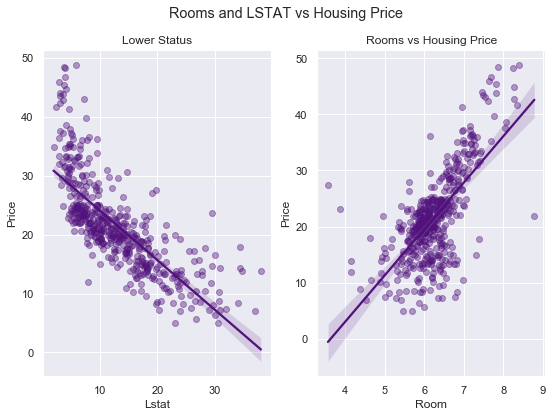

In [68]:
sns.set_palette("magma",3)

fig = plt.figure(facecolor='w', edgecolor='b')

fig, ax = plt.subplots(1,2)
fig.suptitle("Rooms and LSTAT vs Housing Price")
ax0 = sns.regplot('Lstat', 'Price', housing, ax = ax[0], scatter_kws = {'alpha' : 0.4})
ax0.title.set_text('Lower Status')
ax1 = sns.regplot('Room', 'Price', housing, ax = ax[1], scatter_kws = {'alpha' : 0.4})
ax1.title.set_text('Number of Rooms Vs. Housing Price')
plt.title('Rooms vs Housing Price')
plt.show()

# The prices increase as the value of RM increases linearly. There are few outliers and the data seems to be capped at 50.
# The prices tend to decrease with an increase in LSTAT, though it doesn’t look to be following exactly a linear line.

In [49]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# # split into input (X) and output (Y) variables
X = housing.drop('Price', axis=1)
y = housing['Price']
# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

# set random seed for reproducibility 
seed = 10
np.random.seed(seed)

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, random_state = seed)
results_baseline = cross_val_score(estimator, X, y, cv=kfold)*-1
# Scikit-learn inverts MSE so that the metric is maximized instead of minimized, so I set to *-1.  

print("Baseline NN CV model:\n")
print("MSE: {:.2f} (Standard Deviation: {:.2f})".format(results_baseline.mean(), results_baseline.std()))

Baseline NN CV model:

MSE: 30.72 (Standard Deviation: 21.06)


### Lift performance by standardizing and setting through a pipeline !

In [50]:
# evaluate model with standardized dataset 

# Standardized model

# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state = seed)
results_standardize = cross_val_score(pipeline, X, y, cv=kfold)*-1
print("Standardized NN model:\n")
print("MSE: {:.2f} (Standard Deviation: {:.2f})".format(results_standardize.mean(), results_standardize.std()))

# wow, quite an improvement ! MSE dropped down to 20

Standardized NN model:

MSE: 20.21 (Standard Deviation: 11.40)


## Performance improvement by adding more layers

In [70]:
# Evaluate the larger, deeper neural network model

# define the model
def larger_model():
	# create model
	model = Sequential()
	model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
	model.add(Dense(6, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state = seed)

results_deep = cross_val_score(pipeline, X, y, cv=kfold) *-1
print("Deeper NN model:\n")
print("MSE: {:.2f} (Standard Deviation: {:.2f})".format(results_deep.mean(), results_deep.std()))  

C:\Users\eklas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Deeper NN model:

MSE: 17.29 (Standard Deviation: 11.26)


In [26]:
# Evaluate a wider Network Topology
# a different approach to increasing the representational capacity of the model by creating a wider network

seed = 10
np.random.seed(seed)

# define wider model
def wider_model():
	# create model
	model = Sequential()
	model.add(Dense(20, input_dim=13, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state = seed)
results_wide = cross_val_score(pipeline, X, y, cv=kfold)*-1

print("Wider NN model:\n")
print("MSE: {:.2f} (Standard Deviation: {:.2f})".format(results_wide.mean(), results_wide.std())) 

# building a wider model drops the mean square error slightly

C:\Users\eklas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Wider NN model:

MSE: 14.18 (Standard Deviation: 6.23)


## Model Comparison Ranking:

 - Wider NN MSE: 14.11
 - Linear Regression MSE: 17.06
 - Deeper NN : MSE = 17.29
 - Standardized NN : MSE = 20.21
 - Baseline NN model MSE: MSE: 30.77

162/162 [==============================] - 0s 56us/step
Train MSE: 4.311, Test MSE: 23.380


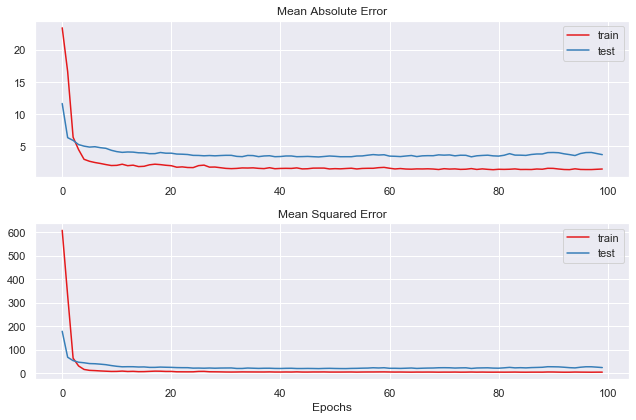

In [21]:
# Comparing MAE with MSE loss function

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
from numpy import loadtxt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from matplotlib import pyplot

# standardize dataset
X = StandardScaler().fit_transform(X)
# y = StandardScaler().fit_transform(y.reshape(len(y),1))

n_train = 328
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(25, input_dim=13, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mse'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)
# evaluate the model
_, train_mse = model.evaluate(trainX, trainy, verbose=1)
_, test_mse = model.evaluate(testX, testy, verbose=1)
print('Train MSE: %.3f, Test MSE: %.3f' % (train_mse, test_mse))
# plot loss during training
plt.subplot(211)
plt.title('Mean Absolute Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot mse during training
plt.subplot(212)
plt.title('Mean Squared Error')
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.xlabel("Epochs")
plt.tight_layout()
plt.show()

# The MSE converged quite nicely over the 100 epochs. 

162/162 [==============================] - 0s 67us/step
Train MSE: 10.530, Test MSE: 64.868



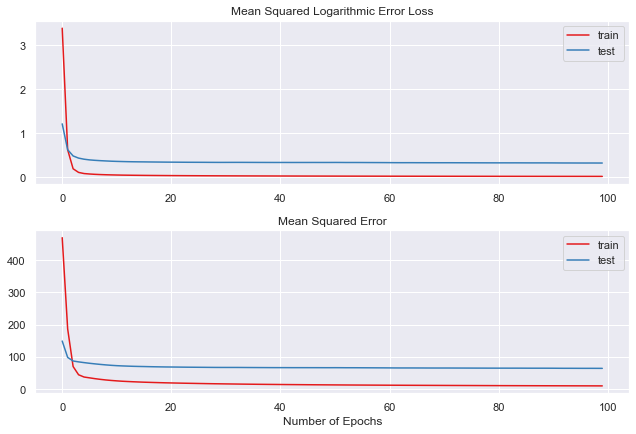

In [22]:
# Comparing Mean Square Logarithmic Error with Mean Squared Error

# define model
model = Sequential()
model.add(Dense(25, input_dim= 13, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear')) # one node for output layer
opt = SGD(lr=0.01, momentum=0.9) # vals obtained from our investigation
model.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=['mse']) #
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)
# evaluate the model
_, train_mse = model.evaluate(trainX, trainy, verbose=1)
_, test_mse = model.evaluate(testX, testy, verbose=1)
print('Train MSE: %.3f, Test MSE: %.3f\n' % (train_mse, test_mse))
# plot loss during training
plt.tight_layout()
plt.subplot(211)
plt.title('Mean Squared Logarithmic Error Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
# plot mse during training
plt.subplot(212)
plt.title('Mean Squared Error')
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.tight_layout()
plt.xlabel("Number of Epochs")
plt.show()

# The MSLE did not converge very well over the 100 epochs. 
# 